In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import datetime

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
def load_data(input_path):
    df = pd.read_csv(input_path)
    # Convert datetime to pandas datetime
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

In [13]:
def preprocess_data(df):
    # Extract time-based features
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    df['day'] = df['DateTime'].dt.day

    # Sort by datetime
    df = df.sort_values('DateTime')

    return df

In [14]:
def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length)]
        y = targets[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dilation, dropout=0.2):
        super(ResidualBlock, self).__init__()
        # Causal padding is (kernel_size-1) * dilation
        padding = (kernel_size-1) * dilation

        # PyTorch doesn't have a built-in causal padding, so we need to pad manually
        self.causal_padding1 = nn.ConstantPad1d((padding, 0), 0)
        self.conv1 = nn.Conv1d(input_channels, output_channels, kernel_size, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(output_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.causal_padding2 = nn.ConstantPad1d((padding, 0), 0)
        self.conv2 = nn.Conv1d(output_channels, output_channels, kernel_size, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(output_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Skip connection
        self.downsample = nn.Conv1d(input_channels, output_channels, 1) if input_channels != output_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x

        # Apply causal padding before convolution
        out = self.causal_padding1(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Apply causal padding before convolution
        out = self.causal_padding2(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        # Make sure the residual and output have the same size
        if self.downsample is not None:
            residual = self.downsample(residual)

        # Ensure shapes match for addition
        out = out[:, :, -residual.size(2):]

        return self.relu(out + residual)

In [16]:
class TCNModel(nn.Module):
    def __init__(self, input_channels, output_size, num_channels=64, kernel_size=3,
                 dropout=0.2, dilations=[1, 2, 4, 8, 16, 32]):
        super(TCNModel, self).__init__()

        # Initial causal convolution with padding
        self.causal_padding = nn.ConstantPad1d((kernel_size-1, 0), 0)
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=kernel_size)

        # Residual blocks with increasing dilation
        self.residual_blocks = nn.ModuleList()
        for dilation in dilations:
            self.residual_blocks.append(
                ResidualBlock(num_channels, num_channels, kernel_size, dilation, dropout)
            )

        # Final layers
        self.fc1 = nn.Linear(num_channels, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        # Input shape: [batch, seq_len, features]
        # Convert to [batch, features, seq_len] for 1D convolution
        x = x.transpose(1, 2)

        # Apply causal padding before first convolution
        x = self.causal_padding(x)
        x = self.conv1(x)

        for block in self.residual_blocks:
            x = block(x)

        # Take the last time step
        x = x[:, :, -1]

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [17]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [18]:
def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=0.001, patience=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.0001)
    early_stopping = EarlyStopping(patience=patience, path='tcn_model_checkpoint.pt')

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Learning rate scheduler
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load best model
    model.load_state_dict(torch.load('tcn_model_checkpoint.pt'))

    return model, train_losses, val_losses

In [19]:
def predict(model, data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch_x, _ in data_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            predictions.append(outputs.cpu().numpy())

    return np.concatenate(predictions).flatten()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unique junctions in dataset: [1 2 3 4]
Unique junctions in training set: [1 2 3]
Unique junctions in validation set: [1 3 4 2]
X_train shape: (30720, 24, 5)
y_train shape: (30720,)
X_val shape: (17352, 24, 5)
y_val shape: (17352,)
TCNModel(
  (causal_padding): ConstantPad1d(padding=(2, 0), value=0)
  (conv1): Conv1d(5, 64, kernel_size=(3,), stride=(1,))
  (residual_blocks): ModuleList(
    (0): ResidualBlock(
      (causal_padding1): ConstantPad1d(padding=(2, 0), value=0)
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (causal_padding2): ConstantPad1d(padding=(2, 0), value=0)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momen

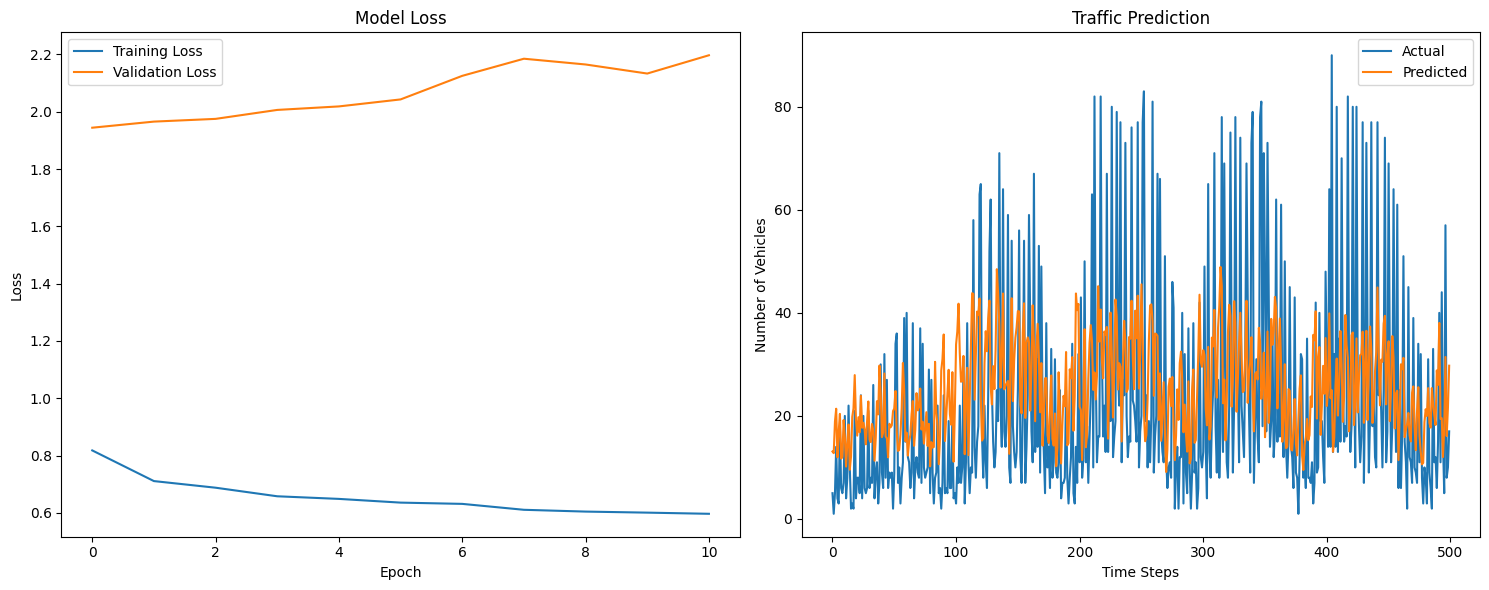


Junction 2 Metrics:
RMSE: 12.64
R² Score: -1.3527


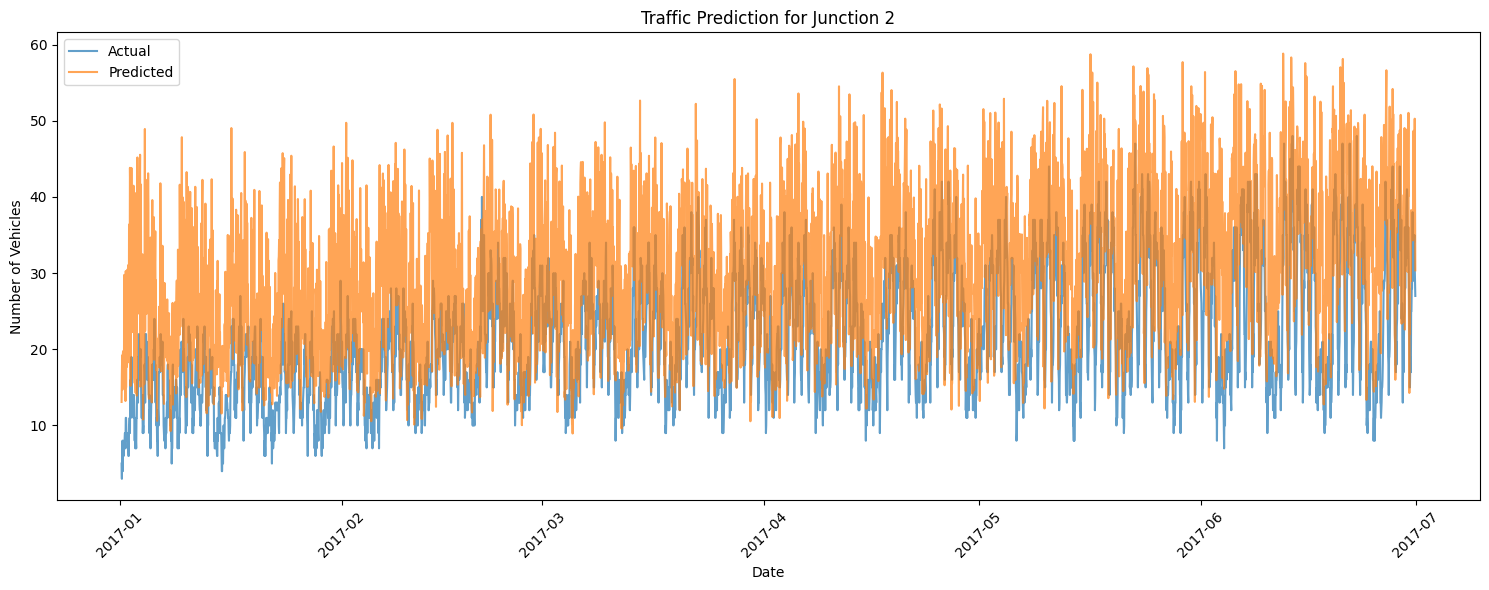


Junction 4 Metrics:
RMSE: 21.08
R² Score: -34.8975


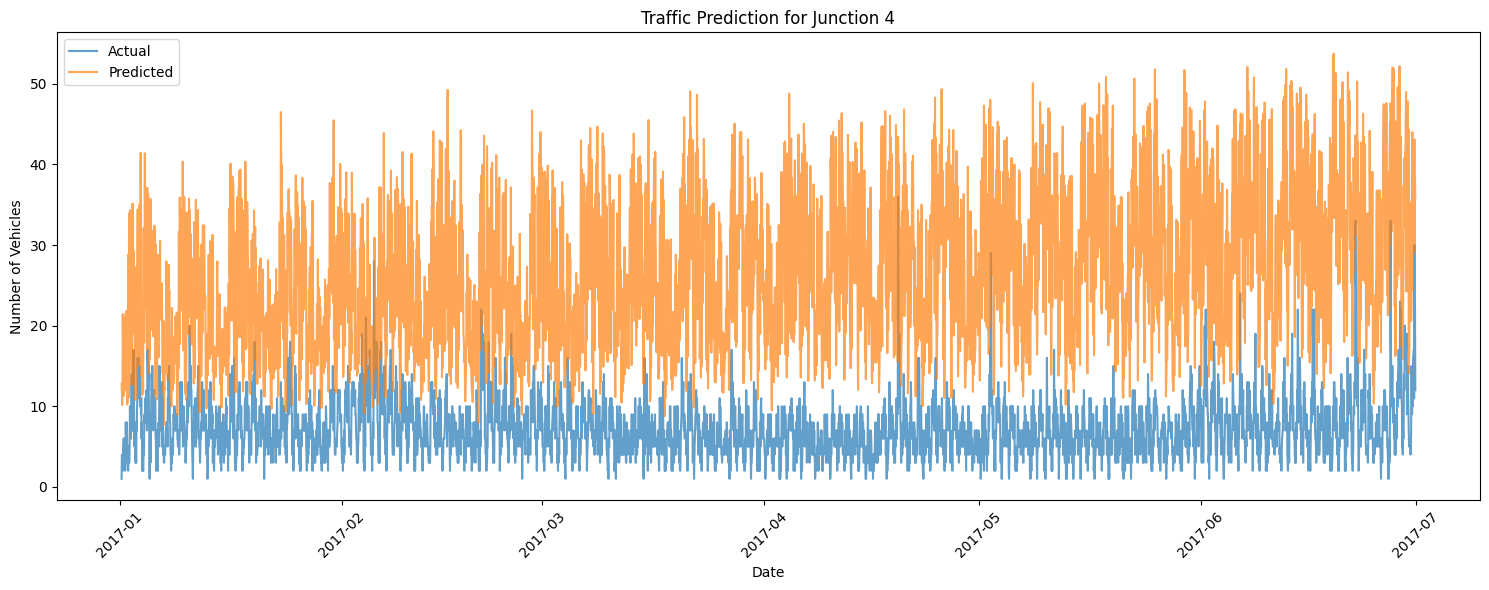


Junction 3 Metrics:
RMSE: 16.93
R² Score: -1.1968


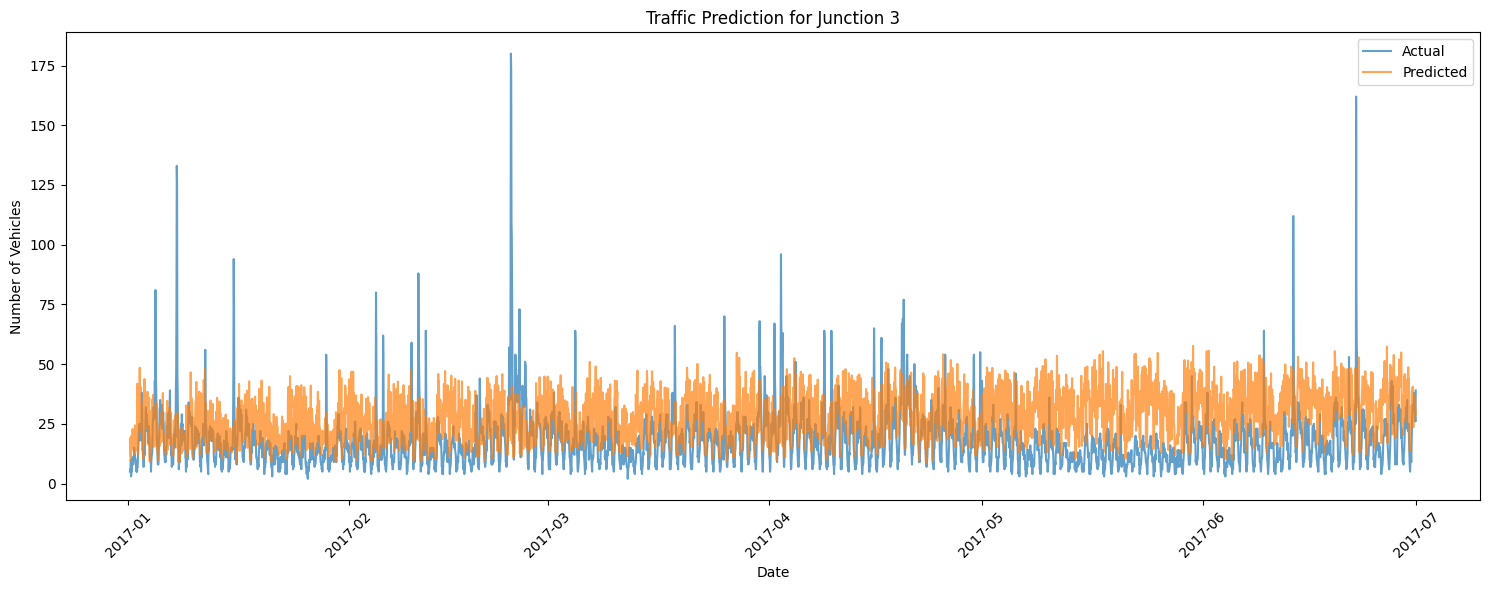


Junction 1 Metrics:
RMSE: 35.12
R² Score: -1.3729


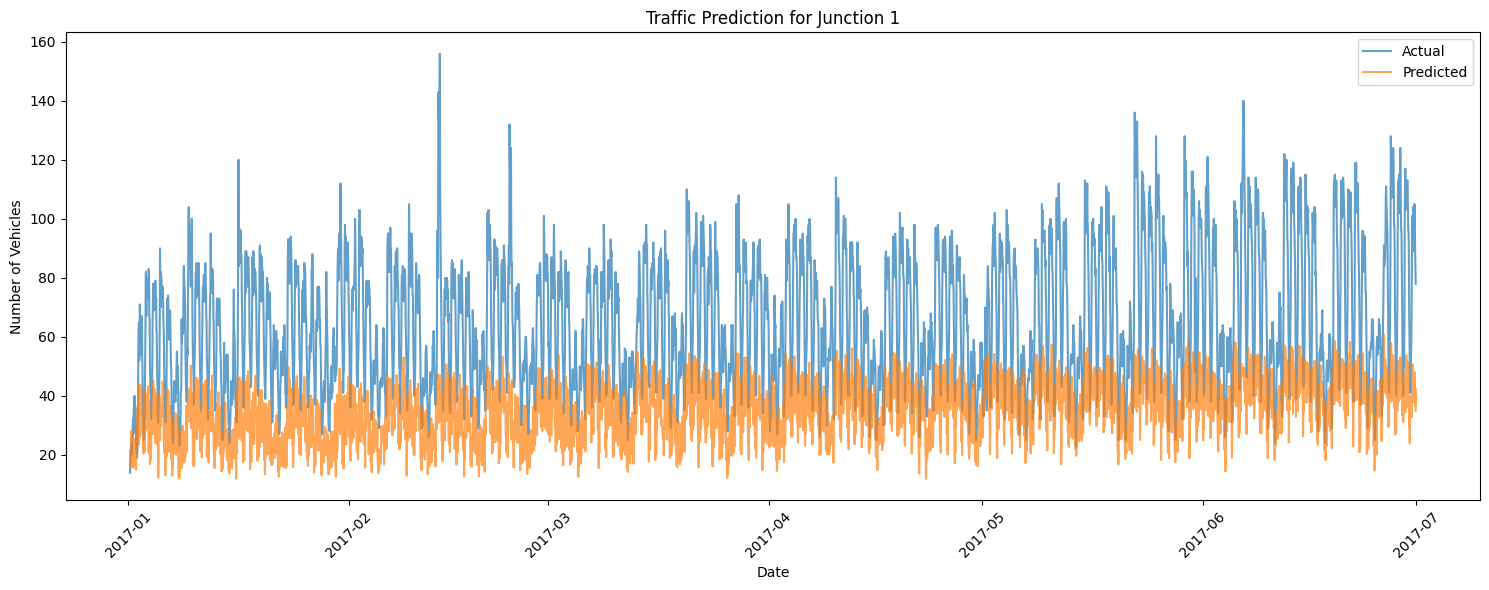

In [20]:
def main():
    # Mount Google Drive (for Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        input_path = '/content/drive/MyDrive/Deep Learning Group 12/Deep Learning Group 12/traffic.csv'
    except Exception as e:
        print(f"Failed to mount Google Drive: {e}")
        input_path = 'traffic.csv'  # Local path

    # Load and preprocess data
    df = load_data(input_path)
    df = preprocess_data(df)

    # Print unique junctions to understand the data
    print("Unique junctions in dataset:", df['Junction'].unique())

    # Split data by time (2015-2016 for training, 2017 for validation)
    train_df = df[df['DateTime'] < '2017-01-01']
    val_df = df[df['DateTime'] >= '2017-01-01']

    print("Unique junctions in training set:", train_df['Junction'].unique())
    print("Unique junctions in validation set:", val_df['Junction'].unique())

    # Prepare features and target
    feature_cols = ['hour', 'day_of_week', 'month', 'day']
    target_col = 'Vehicles'

    # Scale numerical features
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()

    # Transform training data
    train_features_scaled = scaler_features.fit_transform(
        train_df[['Junction'] + feature_cols])
    train_target_scaled = scaler_target.fit_transform(
        train_df[[target_col]]).flatten()

    # Transform validation data
    val_features_scaled = scaler_features.transform(
        val_df[['Junction'] + feature_cols])
    val_target_scaled = scaler_target.transform(
        val_df[[target_col]]).flatten()

    # Create sequences
    seq_length = 24  # Use 24 hours of data to predict the next hour
    X_train, y_train = create_sequences(train_features_scaled, train_target_scaled, seq_length)
    X_val, y_val = create_sequences(val_features_scaled, val_target_scaled, seq_length)

    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train).float()
    y_train_tensor = torch.tensor(y_train).float()
    X_val_tensor = torch.tensor(X_val).float()
    y_val_tensor = torch.tensor(y_val).float()

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model
    input_channels = X_train.shape[2]  # Number of features
    model = TCNModel(input_channels=input_channels, output_size=1).to(device)

    # Print model summary
    print(model)

    # Train model
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        num_epochs=25, learning_rate=0.001, patience=10
    )

    # Make predictions
    val_pred = predict(model, val_loader)

    # Inverse transform predictions and actual values
    val_pred_orig = scaler_target.inverse_transform(val_pred.reshape(-1, 1)).flatten()
    y_val_orig = scaler_target.inverse_transform(y_val.reshape(-1, 1)).flatten()

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val_orig, val_pred_orig))
    r2 = r2_score(y_val_orig, val_pred_orig)

    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")

    # Plot results
    plt.figure(figsize=(15, 6))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot predictions vs actual
    plt.subplot(1, 2, 2)
    plt.plot(y_val_orig[:500], label='Actual')
    plt.plot(val_pred_orig[:500], label='Predicted')
    plt.title('Traffic Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Vehicles')
    plt.legend()

    plt.tight_layout()
    plt.savefig('traffic_prediction_results.png')
    plt.show()

    # Save model
    torch.save(model.state_dict(), 'traffic_tcn_model.pth')

    # Backtesting: Analyze predictions by junction
    # We need to map back the predictions to the original data
    # First, get the corresponding rows from the validation set
    val_indices = list(range(seq_length, len(val_df)))[:len(val_pred_orig)]

    # Create a DataFrame with predictions and actual values
    backtest_df = pd.DataFrame({
        'DateTime': val_df.iloc[val_indices]['DateTime'].values,
        'Junction': val_df.iloc[val_indices]['Junction'].values,
        'Actual': y_val_orig,
        'Predicted': val_pred_orig
    })

    # Analyze by junction
    for junction in backtest_df['Junction'].unique():
        junction_df = backtest_df[backtest_df['Junction'] == junction]

        if len(junction_df) > 0:  # Only analyze if we have data for this junction
            # Calculate junction-specific metrics
            junction_rmse = np.sqrt(mean_squared_error(
                junction_df['Actual'], junction_df['Predicted']))
            junction_r2 = r2_score(junction_df['Actual'], junction_df['Predicted'])

            print(f"\nJunction {junction} Metrics:")
            print(f"RMSE: {junction_rmse:.2f}")
            print(f"R² Score: {junction_r2:.4f}")

            # Plot junction-specific results
            plt.figure(figsize=(15, 6))
            plt.plot(junction_df['DateTime'], junction_df['Actual'],
                     label='Actual', alpha=0.7)
            plt.plot(junction_df['DateTime'], junction_df['Predicted'],
                     label='Predicted', alpha=0.7)
            plt.title(f'Traffic Prediction for Junction {junction}')
            plt.xlabel('Date')
            plt.ylabel('Number of Vehicles')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f'junction_{junction}_prediction.png')
            plt.show()

if __name__ == "__main__":
    main()